## Convolutions Neural Network

In this exercise we are going to build out own model from scratch and the general rule-of-thumb for selectin humber of layers and their nodes are following. 

*(This is not writing on the stone, but a general rule-of thumb, it will vary based on the application)*

**Input layer:** 
Shape of your Neural network, consider the number of features in your data as your number of nodes in the NN. In columnar dataset, the number of columns are your features (ex: age, gender, height, weight, activity level, …), and hence these features become your number of nodes. You can add one node extra to accommodate bias. 

**Output Layer:**
Based on type of NN:
Regression : The output layer will have single node.
Classifier : The output layer will have nodes equal to the number of class labels.   


**Hidden Layers:**
If your data is linearly separable then you do not need NN. Few hidden layers can also solve lot of problems. The rule of thumb is for getting decent performance are: 1) Number of hidden layers equal to one and 2) The number of neutrons in that layer is the mean of the neutrons in the input and output layers.

There's one additional rule of thumb that helps for supervised learning problems. You can usually prevent over-fitting if you keep your number of neurons below:


```
            𝑁ℎ = 𝑁𝑠 / (𝛼∗(𝑁𝑖+𝑁𝑜))
```


*   𝑁𝑖 = number of input neurons.
*   𝑁𝑜 = number of output neurons.
*   𝑁𝑠 = number of samples in training data set.
*   𝛼 = an arbitrary scaling factor usually 2-10.




In [0]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# For reproducible results. 

def torch_seeding(seed):
    if torch.cuda.is_available():
      # for CUDA
      if torch.cuda.device_count() > 1:
        torch.cuda.manual_seed_all(seed)
      else:
        torch.cuda.manual_seed(seed)
      if torch.backends.cudnn.is_available():
        torch.backends.cudnn.deterministic=True

      return torch.device("cuda:0")

    else:
      # for CPU
      torch.manual_seed(seed)

      return torch.device("cpu")

device = torch_seeding(1122)

### How to Initialize weights and biases:

Check this great post to understand more about [xavier initialization](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/). 

In [0]:
# Intialize weights with Xavier

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [4]:
# Hyper parameters
batch_size = 10
num_classes = 10
learning_rate = 0.0003 # 3e-4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# # CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

# Data set
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                             train=True,
                                             download=True, 
                                             transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            download=True, 
                                            transform=transform)
# Data loader

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### How layer are strctured specially in CNN.

```
Convention : -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
```

In [0]:

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes))
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(-1, 16 * 5 * 5)
        out = self.classifier(out)
        return out

In [0]:
model = ConvNet(num_classes).to(device)
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
print(model)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [11]:
# Few more Hyper parameters
num_epochs = 5

# Train the model

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [batch_sz, channels, width, height] = 4, 3, 32, 32
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, n_total_steps, loss.item()))

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)



Epoch [1/5], Step [1000/5000], Loss: 1.1053
Epoch [1/5], Step [2000/5000], Loss: 1.1917
Epoch [1/5], Step [3000/5000], Loss: 0.9730
Epoch [1/5], Step [4000/5000], Loss: 1.0369
Epoch [1/5], Step [5000/5000], Loss: 1.1784
Epoch [2/5], Step [1000/5000], Loss: 1.5685
Epoch [2/5], Step [2000/5000], Loss: 1.3021
Epoch [2/5], Step [3000/5000], Loss: 1.0582
Epoch [2/5], Step [4000/5000], Loss: 1.5120
Epoch [2/5], Step [5000/5000], Loss: 1.6738
Epoch [3/5], Step [1000/5000], Loss: 1.0902
Epoch [3/5], Step [2000/5000], Loss: 1.6066
Epoch [3/5], Step [3000/5000], Loss: 0.9425
Epoch [3/5], Step [4000/5000], Loss: 1.2166
Epoch [3/5], Step [5000/5000], Loss: 1.1325
Epoch [4/5], Step [1000/5000], Loss: 1.0193
Epoch [4/5], Step [2000/5000], Loss: 0.8864
Epoch [4/5], Step [3000/5000], Loss: 1.4909
Epoch [4/5], Step [4000/5000], Loss: 1.2610
Epoch [4/5], Step [5000/5000], Loss: 1.3279
Epoch [5/5], Step [1000/5000], Loss: 0.5735
Epoch [5/5], Step [2000/5000], Loss: 1.0882
Epoch [5/5], Step [3000/5000], L

In [12]:
# Validation time

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 62.71 %
Accuracy of plane: 70.3 %
Accuracy of car: 81.7 %
Accuracy of bird: 47.9 %
Accuracy of cat: 36.5 %
Accuracy of deer: 59.2 %
Accuracy of dog: 62.2 %
Accuracy of frog: 73.7 %
Accuracy of horse: 62.1 %
Accuracy of ship: 76.3 %
Accuracy of truck: 57.2 %


## Visualization

In [0]:

def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)


def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()


def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")


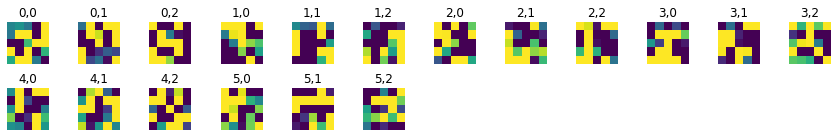

In [14]:
plot_weights(model, 0, single_channel = True)

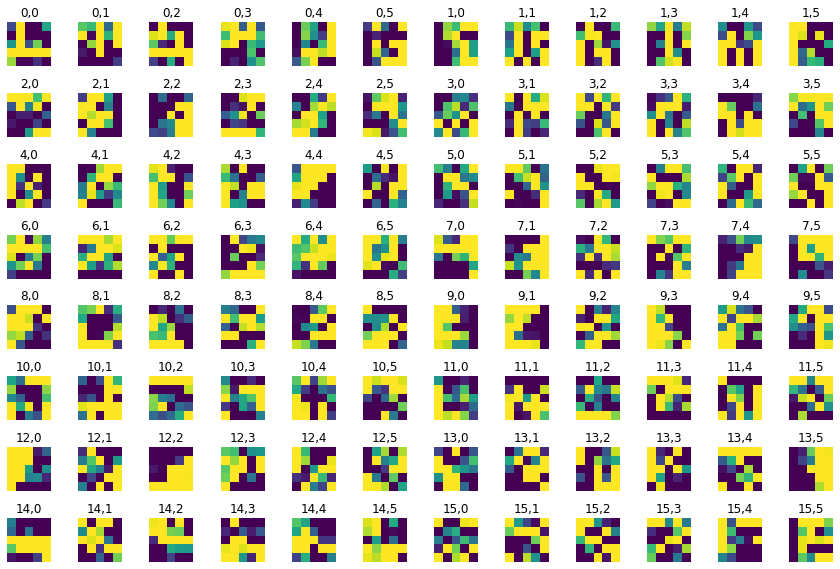

In [15]:
plot_weights(model, 4, single_channel = True)

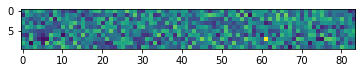

In [19]:
plt.imshow(model.classifier[4].weight.data)